<div align="center">
    <img src='../../xepimage.png' style='height:100px;'>
</div>


<center><h1 style='font-size:25px'>Model</h1></center>

---

**Autor: Guillermo J. Bergues**

Autogluon for Xepelin project.

Data = Outliers (second approach).

In [1]:
! /opt/miniconda3/envs/myenv/bin/pip install --no-cache-dir autogluon -q

In [2]:
import pandas as pd 
import numpy as np

from autogluon.tabular import TabularPredictor, TabularDataset

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/opt/miniconda3/envs/myenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv ('../../Data/ds_outliers.csv')

In [4]:
df.head()

,PayerId,ReceiverId,days,amount,amountfinancedByXepelin
0,151,19,0,1490.46,0.00
1,126,18,0,920.26,0.00
2,114,37,7,4035.26,0.00
3,122,12,10,27979.20,10520.15
4,55,34,22,1477.46,0.00


<AxesSubplot:>

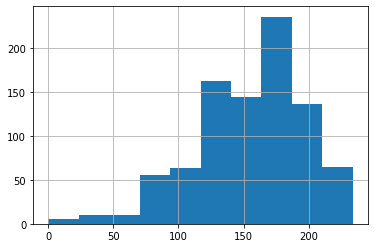

In [5]:
df['days'].hist()

In [6]:
save_path = "agModels"

In [7]:
df_train = df[df["days"] < 180]

In [8]:
label = 'amountfinancedByXepelin'

In [9]:
df_train = TabularDataset(df)

In [10]:
predictor = TabularPredictor(label=label, path=save_path, eval_metric='median_absolute_error').fit(df_train, time_limit=18000)

Beginning AutoGluon training ... Time limit = 18000s
AutoGluon will save models to "agModels/"
AutoGluon Version:  0.4.2
Python Version:     3.8.10
Operating System:   Linux
Train Data Rows:    891
Train Data Columns: 4
Label Column: amountfinancedByXepelin
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1285010.2, 0.0, 14785.82659, 69037.3032)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    62945.44 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadat

In [11]:
test_data = df[df["days"] >= 180]

In [12]:
df_test = TabularDataset(test_data)

In [13]:
# values to predict
y_test = df_test[label]  

In [14]:
# delete label column to prove we're not cheating
test_data_nolab = df_test.drop(columns=[label])  

In [15]:
test_data_nolab.head()

,PayerId,ReceiverId,days,amount
627,174,82,182,1792.46
628,187,55,182,725.46
629,173,35,183,5220.00
630,110,46,183,4035.06
631,199,46,183,1490.26


In [16]:
predictor = TabularPredictor.load(save_path)  

In [17]:
y_pred = predictor.predict(test_data_nolab)
print("Predictions:  \n", y_pred)

Predictions:  
 627       0.000000
628       0.000000
629    3007.909912
630       0.000000
631       0.000000
          ...     
886       0.000000
887       0.000000
888       0.000000
889    8965.536133
890       0.000000
Name: amountfinancedByXepelin, Length: 264, dtype: float32


In [18]:
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

Evaluation: median_absolute_error on test data: -0.0
Evaluations on test data:
{
    "median_absolute_error": -0.0,
    "root_mean_squared_error": -19700.152125374647,
    "mean_squared_error": -388095993.76290315,
    "mean_absolute_error": -5263.93818773443,
    "r2": 0.8635079385813069,
    "pearsonr": 0.953817621224473
}


In [19]:
# Predictions and test data set
df_test_pred = pd.concat([y_test, y_pred], axis=1)
df_test_pred.columns = ['test', 'prediction']
df_test_pred['residual'] = df_test_pred['test'] - df_test_pred['prediction']
df_test_pred.head()

,test,prediction,residual
627,0.0,0.000000,0.000000
628,0.0,0.000000,0.000000
629,5220.0,3007.909912,2212.090088
630,0.0,0.000000,0.000000
631,0.0,0.000000,0.000000


Text(0, 0.5, 'Predicted values')

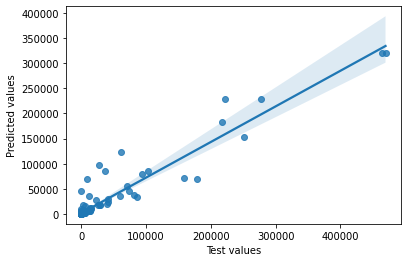

In [20]:
sns.regplot(x=y_test, y=y_pred);
plt.xlabel('Test values')
plt.ylabel('Predicted values')

In [21]:
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,KNeighborsUnif,-0.000000e+00,-0.000000e+00,0.007846,0.007867,0.005641,0.007846,0.007867,0.005641,1,True,1
1,KNeighborsDist,-0.000000e+00,-0.000000e+00,0.008288,0.006966,0.004221,0.008288,0.006966,0.004221,1,True,2
2,WeightedEnsemble_L2,-0.000000e+00,-0.000000e+00,0.011280,0.008304,0.316850,0.003434,0.000437,0.311209,2,True,12
3,ExtraTreesMSE,-0.000000e+00,-3.333367e+00,0.080320,0.067772,0.579705,0.080320,0.067772,0.579705,1,True,7
4,RandomForestMSE,-0.000000e+00,-0.000000e+00,0.082136,0.069108,0.610659,0.082136,0.069108,0.610659,1,True,5
5,NeuralNetTorch,-5.607631e-11,-6.060819e-11,0.042833,0.007909,52.599801,0.042833,0.007909,52.599801,1,True,10
6,XGBoost,-5.982359e-01,-5.982359e-01,0.008949,0.005622,0.428714,0.008949,0.005622,0.428714,1,True,9
7,LightGBMLarge,-1.326024e+01,-1.981702e+01,0.018182,0.004134,1.018121,0.018182,0.004134,1.018121,1,True,11
8,LightGBM,-1.274595e+02,-1.974680e+02,0.008081,0.003095,0.415765,0.008081,0.003095,0.415765,1,True,4
9,CatBoost,-4.557222e+02,-6.634815e+02,0.004380,0.001828,2.321536,0.004380,0.001828,2.321536,1,True,6


In [22]:
# Metrics
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 5263.93818773443
MSE: 388095993.76290315
RMSE: 19700.152125374647


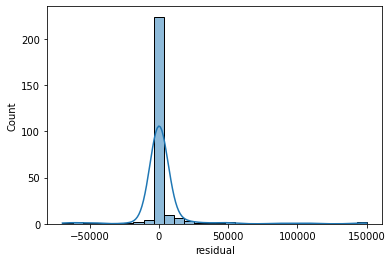

In [23]:
# Distributions of residuals
sns.histplot(data=df_test_pred, x='residual', kde=True, bins=30);

In [24]:
f_importance = predictor.feature_importance(df_test)
f_importance.head()

Computing feature importance via permutation shuffling for 4 features using 264 rows with 5 shuffle sets...
	0.38s	= Expected runtime (0.08s per shuffle set)
	0.11s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
PayerId,0.0,0.0,0.5,5,0.0,0.0
ReceiverId,0.0,0.0,0.5,5,0.0,0.0
days,0.0,0.0,0.5,5,0.0,0.0
amount,0.0,0.0,0.5,5,0.0,0.0
